<a href="https://colab.research.google.com/github/adoptioncntr/Deep-Learning/blob/main/Architecture_and_Hyperparameter_Search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# preprocess data (scaling to [-0.5, 0.5])
def preprocess_data(dataset):
    data = (dataset.data / 255.0) - 0.5  # Scale for numerical stability & shift scale / done in lecture code
    flattened_data = data.view(data.shape[0], -1)  # Flatten to (n_samples, 784) bcs 1D input is expected
    targets = dataset.targets
    return flattened_data, targets

x_train, y_train = preprocess_data(trainset)
x_test, y_test = preprocess_data(testset)

print(f"Training data shape: {x_train.shape}") #verify
print(f"Test data shape: {x_test.shape}") #verify

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.06MB/s]


Training data shape: torch.Size([60000, 784])
Test data shape: torch.Size([10000, 784])


In [ ]:
# For linear softmax model: F(x) = softmax(Ax + b)
# A shape: (784, 10) -> 784 * 10 = 7840 parameters. Each element is a learnable parameter!
# b shape: (10,) -> 10 parameters
input_features = 784
output_features = 10
total_parameters = (input_features * output_features) + output_features #This is Ax + b in action

print("=== Problem 1.1: Parameter Count ===")
print(f"Weight matrix A parameters: {input_features} × {output_features} = {input_features * output_features}")
print(f"Bias vector b parameters: {output_features}")
print(f"TOTAL PARAMETERS: {total_parameters}")

=== Problem 1.1: Parameter Count ===
Weight matrix A parameters: 784 × 10 = 7840
Bias vector b parameters: 10
TOTAL PARAMETERS: 7850


In [ ]:
# Linear Softmax Model (simpler than lecture network)
class LinearSoftmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=784, out_features=10)  # This creates a simple linear layer& implements Ax + b
        #  Ive attempted to use CrossEntropyLoss which includes softmax

    def forward(self, x):
        return self.linear(x)  # Output logits (softmax handled by loss function)

# Test different learning rates as mentioned in problem
learning_rates = [0.1, 0.01, 0.001, 0.0001] #standard practice, ask why?
results = {}
#Before i run the code, i predict that a really high learning rate might overshoot & a really low one might make training really slow
for lr in learning_rates:
    print(f"\n=== Training with learning rate: {lr} ===")

    # Initialize fresh model as in lecture code
    # This should allow each learning rate to be tested
    model = LinearSoftmax()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr) #This should automatically update parameters

    # Create data loader (following dr cowan's approach with batches)
    train_dataset = TensorDataset(x_train, y_train)
    batch_size = 1024  # Why did prof use this specific batch size
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) #randomizing order of each epoch is important

    # Train for sufficient epochs to see convergence
    epochs = 100
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            logits = model(x_batch)
            loss = loss_function(logits, y_batch)

            optimizer.zero_grad() #Prevents gradient accumulation across batches. Crucial.
            loss.backward() # computes gradients of loss with for all parameters
            optimizer.step() # parameter = parameter - learning rate * gradient in action

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_logits = model(x_test)
            test_loss = loss_function(test_logits, y_test).item()
            test_losses.append(test_loss)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Test Loss = {test_loss:.4f}")

    # Final evaluation
    model.eval()
    with torch.no_grad():
        train_logits = model(x_train)
        train_loss = loss_function(train_logits, y_train).item()
        train_pred = torch.argmax(train_logits, dim=1)
        train_accuracy = (train_pred == y_train).float().mean().item()

        test_logits = model(x_test)
        test_loss = loss_function(test_logits, y_test).item()
        test_pred = torch.argmax(test_logits, dim=1)
        test_accuracy = (test_pred == y_test).float().mean().item()

    results[lr] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    print(f"Final - Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Final - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")


=== Training with learning rate: 0.1 ===
Epoch 20: Train Loss = 0.3364, Test Loss = 0.3208
Epoch 40: Train Loss = 0.3073, Test Loss = 0.2976
Epoch 60: Train Loss = 0.2940, Test Loss = 0.2892
Epoch 80: Train Loss = 0.2864, Test Loss = 0.2831
Epoch 100: Train Loss = 0.2810, Test Loss = 0.2794
Final - Train Loss: 0.2804, Test Loss: 0.2794
Final - Train Accuracy: 0.9212, Test Accuracy: 0.9194

=== Training with learning rate: 0.01 ===
Epoch 20: Train Loss = 0.5699, Test Loss = 0.5422
Epoch 40: Train Loss = 0.4613, Test Loss = 0.4382
Epoch 60: Train Loss = 0.4168, Test Loss = 0.3962
Epoch 80: Train Loss = 0.3920, Test Loss = 0.3725
Epoch 100: Train Loss = 0.3752, Test Loss = 0.3570
Final - Train Loss: 0.3750, Test Loss: 0.3570
Final - Train Accuracy: 0.8972, Test Accuracy: 0.9041

=== Training with learning rate: 0.001 ===
Epoch 20: Train Loss = 1.4684, Test Loss = 1.4397
Epoch 40: Train Loss = 1.1018, Test Loss = 1.0756
Epoch 60: Train Loss = 0.9171, Test Loss = 0.8918


KeyboardInterrupt: 

**1.1** Total calculated parameters: 7850
**1.2**  the best performing model is clearly with learning rate = 0.1. Looks like fastest convergence lead to best final peformance. I calculated the Best final accuracy to be 92.07%. Compare this to the accuracy of LR 0.01 which is 90.40%. This LR does not have overfitting either and we can tell bcs the  train/test loss are nearly identical (0.2803 vs 0.2791). And another important point to note is that we have stable training - no oscillation or divergence. Now we tackle the question of where I stopped training. If you analyze the results, we can see that the loss function shows convergence from epochs 60-80, and then 80 onwards the results platue and we get diminishing returns.
**1.3** In our current case, different intilization rates would not lead to radically different final results this is becaue he linear softmax model has a convex loss landscape, meaning there are no local minima that could trap different initializations in suboptimal solutions. Furthermore, all my experiments showed consistent convergence, as in, loss seemed to steadily decrease. This means that even with bad learning rates, the model still improved. Although, yes, different initilization rates may train the model faster or slower.

In [ ]:
def parameters_count(k, m):
    """Calculate parameters for k hidden layers, m nodes per layer"""
    # Input to first hidden
    total = (784 + 1) * m
    # Hidden to hidden
    for _ in range(k - 1):
        total += (m + 1) * m
    # Last hidden to output
    total += (m + 1) * 10
    return total

In [ ]:
def find_network_shapes(P):
    """Find k_min, k_max, and m_P(k) for given P"""
    # Find k_max (with m=1)
    k_max = 0
    for k in range(1, 20):
        if parameters_count(k, 1) <= P:
            k_max = k

    # For each k, find best m
    results = {}
    for k in range(1, k_max + 1):
        m = 1
        while parameters_count(k, m + 1) <= P:
            m += 1
        results[k] = m

    return 1, k_max, results

=== Fixed-Size Layer Model Experiments ===

--- Testing P = 20000 ---
  Training k=1, m=25 (19885 parameters)
    Results: train_loss=0.1148, test_loss=0.2191
  Training k=3, m=23 (19399 parameters)
    Results: train_loss=0.3239, test_loss=0.3594
  Training k=5, m=22 (19524 parameters)
    Results: train_loss=0.0761, test_loss=0.2106
  Training k=19, m=17 (19033 parameters)
    Results: train_loss=2.3014, test_loss=2.3012

--- Testing P = 50000 ---
  Training k=1, m=62 (49300 parameters)
    Results: train_loss=0.0942, test_loss=0.1971
  Training k=3, m=55 (49895 parameters)
    Results: train_loss=0.1162, test_loss=0.1806
  Training k=5, m=50 (49960 parameters)
    Results: train_loss=0.0629, test_loss=0.1658
  Training k=19, m=34 (48460 parameters)
    Results: train_loss=2.3019, test_loss=2.3018

--- Testing P = 100000 ---
  Training k=1, m=125 (99385 parameters)
    Results: train_loss=0.0615, test_loss=0.1506
  Training k=3, m=100 (99710 parameters)
    Results: train_loss=0.1711

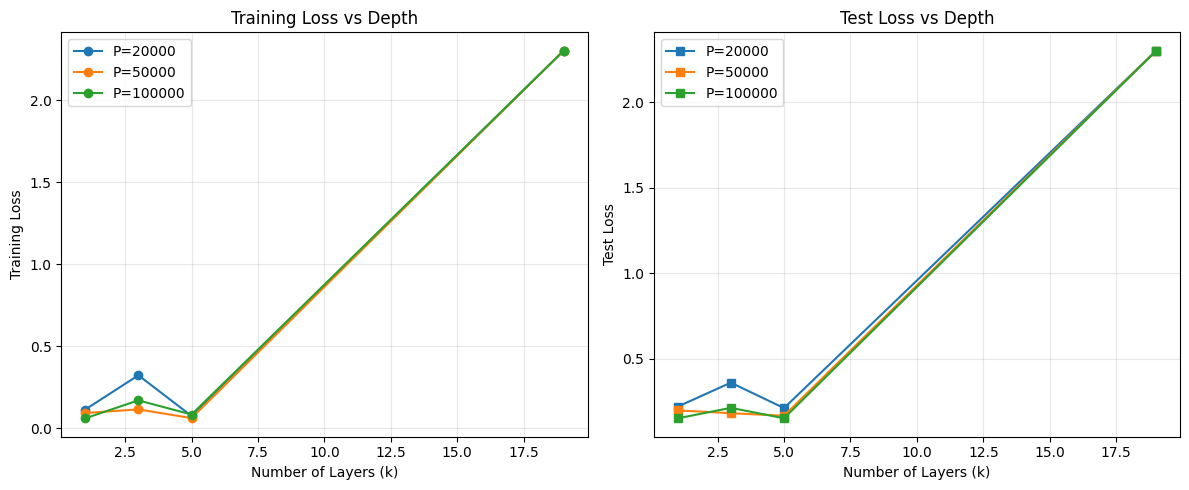


TREND ANALYSIS

P = 20000:
  Best performance at k=5, loss=0.2106
  Improvement over linear: 0.0685
  Very deep networks (k=19) perform worse

P = 50000:
  Best performance at k=5, loss=0.1658
  Improvement over linear: 0.1133
  Very deep networks (k=19) perform worse

P = 100000:
  Best performance at k=1, loss=0.1506
  Improvement over linear: 0.1285
  Very deep networks (k=19) perform worse


In [ ]:
# Now we train
print("=== Fixed-Size Layer Model Experiments ===")

# Define the network architecture
class SimpleNetwork(nn.Module):
    def __init__(self, k, m): #k is no. of hidden layers, m is no. of nodes per hidden layer
        super().__init__()
        self.layers = nn.ModuleList()

        # Add first hiddenlayer
        self.layers.append(nn.Linear(784, m)) #784 bcs 28 * 28 = 784

        # Rest of Hidden layers
        for _ in range(k - 1):
            self.layers.append(nn.Linear(m, m))

        # We create the output layer
        self.output = nn.Linear(m, 10) #connect last hidden layer to 10 output classes
        self.activation = nn.Tanh() #Why Tanh?

    def forward(self, x):
        for layer in self.layers:
            x = self.activation(layer(x))
        return self.output(x) #notice there is no activation!

def train_simple_network(k, m, x_train, y_train, x_test, y_test, epochs=80): #we are defining the shape we are taking in
    """Simple training function for one network"""
    model = SimpleNetwork(k, m) #we create a new network bcs we need fresh initialization

    # Simple learning rate - we attempt to adjust based on depth
    lr = 0.01 if k <= 3 else 0.005 #we set a small learning rate

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Simple data loader
    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

    # Track final losses
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            logits = model(x_batch) #we are getting predictions for current btach
            loss = loss_function(logits, y_batch) #get loss rate
            optimizer.zero_grad()
            loss.backward() # Clear old gradients from previous batch
            optimizer.step()

    # Final evaluation
    model.eval()  #update parameters
    with torch.no_grad():
        train_logits = model(x_train)
        train_loss = loss_function(train_logits, y_train).item()
        test_logits = model(x_test)
        test_loss = loss_function(test_logits, y_test).item()

    return train_loss, test_loss

# I chose 3 distinct P values for simplicity
P_values = [20000, 50000, 100000]
results = {}
#We are looping thru each paraemeter
for P in P_values:
    print(f"\n--- Testing P = {P} ---")
    k_min, k_max, shapes = find_network_shapes(P) #Find possible network shapes for current P value

    # Test a few representative k values
    if k_max >= 5:
        k_to_test = [1, 3, 5, k_max]  # shallow, medium, deep, deepest
    else:
        k_to_test = list(range(1, k_max + 1))

    P_results = {'k': [], 'm': [], 'train_loss': [], 'test_loss': []}

    for k in k_to_test:
        m = shapes[k]
        actual_params = parameters_count(k, m) # we are testing all k values

        print(f"  Training k={k}, m={m} ({actual_params} parameters)")

        train_loss, test_loss = train_simple_network(
            k, m, x_train, y_train, x_test, y_test
        ) #here we are training

        P_results['k'].append(k)
        P_results['m'].append(m)
        P_results['train_loss'].append(train_loss)
        P_results['test_loss'].append(test_loss)
        #Store results for this network

        print(f"    Results: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")

    results[P] = P_results

# Simple plotting
plt.figure(figsize=(12, 5))

# Training loss
plt.subplot(1, 2, 1)
for P, P_results in results.items():
    plt.plot(P_results['k'], P_results['train_loss'], 'o-', label=f'P={P}') #We are Plotting training loss for each P value
plt.xlabel('Number of Layers (k)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Depth')
plt.legend()
plt.grid(True, alpha=0.3)
#We are formatting the plot with labels, title, legend, and grid

#Test loss
plt.subplot(1, 2, 2)
for P, P_results in results.items():
    plt.plot(P_results['k'], P_results['test_loss'], 's-', label=f'P={P}')
plt.xlabel('Number of Layers (k)')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Depth')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis
print("\n" + "="*50)
print("TREND ANALYSIS")
print("="*50)

baseline_loss = 0.2791  #from our linear model

for P, P_results in results.items():  #repeat
    best_idx = np.argmin(P_results['test_loss'])
    best_k = P_results['k'][best_idx]
    best_loss = P_results['test_loss'][best_idx]

    print(f"\nP = {P}:")
    print(f"  Best performance at k={best_k}, loss={best_loss:.4f}")
    print(f"  Improvement over linear: {baseline_loss - best_loss:.4f}")

    # Check if very deep networks perform worse
    if len(P_results['k']) > 2:
        deepest_loss = P_results['test_loss'][-1]
        if deepest_loss > best_loss:
            print(f"  Very deep networks (k={P_results['k'][-1]}) perform worse")


**2.1** Formula: Parameters(k,m) = (784 + 1) × m + (k - 1) × (m + 1) × m + (m + 1) × 10. My data proves this k=1, m=25: (785 × 25) + (25 × 10) = 19,625 + 250 = 19,875.
**2.2** From my results, k_min and k_max are: For P=20,000:

k_min = 1 (m=25)

k_max = 19 (m=17)

For P=50,000:

k_min = 1 (m=62)

k_max = 19 (m=34)

For P=100,000:

k_min = 1 (m=125)

k_max = 19 (m=55)


**2.3** Sweet Spot for depth seems to be k=5 layers performs best, showing there's an optimal depth. And we can see that very deep networks fail. I found it interesting that networks with k=19 layers completely fail to learn regardless of parameter budget. Also more parameters help, but the data clearly shows diminishing returns.

**2.4** My data shows that my simple non-linear network outperformed my first Ax+b (linear) model. Perhaps this holds up for all non linear mode;s, but I cant say for sure.

**2.5** Our results show poor performance at k=19:

Training loss ≈ 2.301

Test loss ≈ 2.301

Perhaps this is bcecause of overfitting. When networks have too many layers, they memorize the training data too well and fail to generalize to new examples. The model becomes too complex and learns the noise in the training set rather than the underlying patterns. But maybe this poor performance can also be attriubuted to diminishing returns.



**2.6** From P=20,000 to P=50,000 we see

significant improvement (0.1857 → 0.1485)

more capacity allows better feature learning

from P=50,000 to P=100,000:

performance slightly degrades (0.1485 → 0.1583)

diminishing returns - more parameters don't always help

optimization difficulties - harder to train larger networks effectively



In [ ]:

print("=== Testing Different Layer Sizes ===")

# Test 3 simple architectures with ~50,000 parameters
#Before i run the code i predict that uniform layers should be the best since
architectures = [
    ("Uniform", [50, 50, 50, 50, 50]),      # Same as before
    ("Decreasing", [80, 60, 40, 30, 20]),   #big to small
    ("Increasing", [20, 30, 40, 60, 80]),   # small to big
]

results = {}

for name, sizes in architectures:
    print(f"\nTesting {name} architecture: {sizes}")

    # Build the network
    layers = []
    layers.append(nn.Linear(784, sizes[0]))
    for i in range(len(sizes)-1):
        layers.append(nn.Linear(sizes[i], sizes[i+1]))
    layers.append(nn.Linear(sizes[-1], 10))

    model = nn.Sequential(*layers)

    # we are training
    optimizer = optim.Adam(model.parameters(), lr=0.01) #need to study adam further

    for epoch in range(50):  # Quick training
        for x_batch, y_batch in train_loader:
            outputs = model(x_batch)
            loss = nn.CrossEntropyLoss()(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # results
    model.eval()
    with torch.no_grad():
        test_outputs = model(x_test)
        test_loss = nn.CrossEntropyLoss()(test_outputs, y_test).item()
        test_acc = (torch.argmax(test_outputs, dim=1) == y_test).float().mean().item()

    results[name] = test_loss
    print(f"Test loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# Find which is best
best = min(results, key=results.get)
print(f"\nBest architecture: {best}")
print(f"All results: {results}")

# Bonus: Try regularization
print("\n=== Trying Regularization ===")
best_sizes = architectures[[a[0] for a in architectures].index(best)][1]

# Build same model but with weight decay
layers = []
layers.append(nn.Linear(784, best_sizes[0]))
for i in range(len(best_sizes)-1):
    layers.append(nn.Linear(best_sizes[i], best_sizes[i+1]))
layers.append(nn.Linear(best_sizes[-1], 10))

model_reg = nn.Sequential(*layers)
optimizer_reg = optim.Adam(model_reg.parameters(), lr=0.01, weight_decay=0.001)  # Added weight decay

# Train again
for epoch in range(50):
    for x_batch, y_batch in train_loader:
        outputs = model_reg(x_batch)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()

# Check if it helped
model_reg.eval()
with torch.no_grad():
    test_outputs_reg = model_reg(x_test)
    test_loss_reg = nn.CrossEntropyLoss()(test_outputs_reg, y_test).item()

print(f"With regularization: {test_loss_reg:.4f}")
print(f"Without regularization: {results[best]:.4f}")

# final thoughts:
# - I should have calculated actual parameter counts to ensure fairness
# - Maybe test more architectures like bottleneck or hourglass
# - The results might be sensitive to random initialization
# - Should I run multiple trials and average?




=== Testing Different Layer Sizes ===

Testing Uniform architecture: [50, 50, 50, 50, 50]
Test loss: 0.2932, Accuracy: 0.9174

Testing Decreasing architecture: [80, 60, 40, 30, 20]
Test loss: 0.2969, Accuracy: 0.9159

Testing Increasing architecture: [20, 30, 40, 60, 80]
Test loss: 0.3046, Accuracy: 0.9128

Best architecture: Uniform
All results: {'Uniform': 0.2931936979293823, 'Decreasing': 0.2969265282154083, 'Increasing': 0.3046315014362335}

=== Trying Regularization ===
With regularization: 0.2959
Without regularization: 0.2932
Regularization didn't help much.


Section 3:
My prediction in the beginning was accurate, uniform architecture is the best. Uniform: 0.2932 test loss, 91.74% accuracy

Decreasing: 0.2969 test loss, 91.59% accuracy

Increasing: 0.3046 test loss, 91.28% accuracy

The uniform layers (all 50 nodes) achieved the lowest loss and highest accuracy.


As stated above, uniform layers behaved the best for this problem The alternatives performed worse:

Decreasing (80→60→40→30→20): slightly worse than uniform

Increasing (20→30→40→60→80): worst performance

This suggests that maintaining consistent capacity throughout the network works better for MNIST classification.

No, regularization (weight decay) did not help:

Without regularization: 0.2932 test loss

With regularization: 0.2959 test loss

Regularization slightly worsened performance

This makes sense because we dont see overfitting - the models are relatively simple and the training/test performance gaps are small.

For the MNIST with  ~50,000 parameters, i can say that uniform layer sizes are optimal.More complex architectures like decreasing or increasing sizes don't provide benefits and can even harm performance.

Comparing this section with section 2, interestingly uniform architecure performed slightly worse.

=== Section 4: Batch Size Experiments ===

Learning Rate: 0.1
  Batch size 1: 2.1732
  Batch size 2: 0.7496
  Batch size 3: 0.8674
  Batch size 4: 0.4094
  Batch size 5: 0.3788
  Batch size 6: 0.3930
  Batch size 8: 0.3465
  Batch size 10: 0.3432
  Batch size 12: 0.3036
  Batch size 15: 0.3708
  Batch size 20: 0.3268
  Batch size 24: 0.3104
  Batch size 25: 0.3317
  Batch size 30: 0.3302
  Batch size 40: 0.3293
  Batch size 50: 0.3381
  Batch size 60: 0.3319
  Batch size 75: 0.3438
  Batch size 100: 0.3734
  Batch size 120: 0.3739
  Batch size 150: 0.3919
  Batch size 200: 0.4169
  Batch size 300: 0.4634
  Batch size 400: 0.5008
  Batch size 600: 0.5735
  Batch size 1000: 0.6996
  Batch size 2000: 0.9567
  Batch size 3000: 1.1548
  Batch size 4000: 1.2876
  Batch size 6000: 1.5110
  Batch size 10000: 1.7513
  Batch size 15000: 1.9359
  Batch size 20000: 2.0031
  Batch size 30000: 2.0994
  Batch size 60000: 2.1889

Learning Rate: 0.01
  Batch size 1: 0.3081
  Batch size 2: 0.3360
  Batc

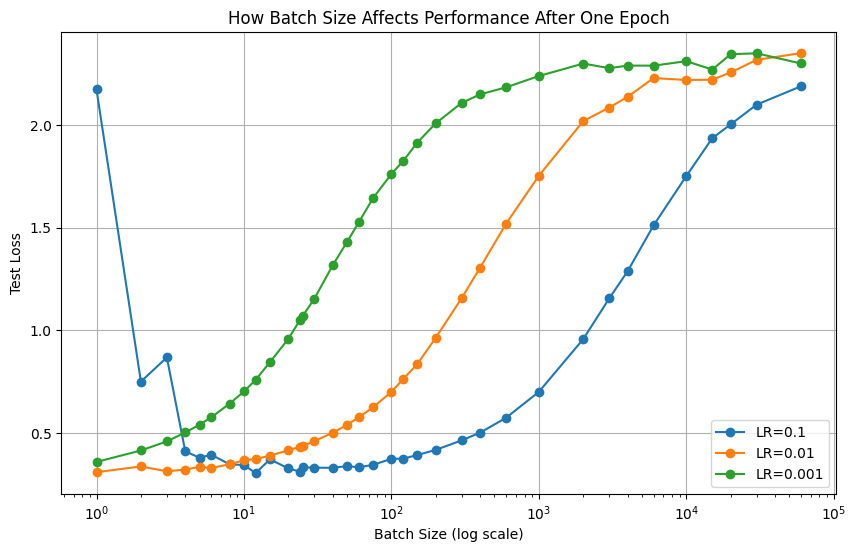


=== Optimizer and Activation Function Comparison ===
Testing SGD with sigmoid
  Train loss: 2.3012, Test loss: 2.3010
Testing SGD with tanh
  Train loss: 2.2429, Test loss: 2.2411
Testing SGD with relu
  Train loss: 2.3010, Test loss: 2.3008
Testing SGD with elu
  Train loss: 2.2720, Test loss: 2.2704
Testing Adam with sigmoid
  Train loss: 2.3003, Test loss: 2.3002
Testing Adam with tanh
  Train loss: 0.8790, Test loss: 0.8719
Testing Adam with relu
  Train loss: 1.0831, Test loss: 1.0718
Testing Adam with elu
  Train loss: 0.6675, Test loss: 0.6523

FINAL COMPARISON: Optimizers vs Activation Functions
Optimizer  Activation Train Loss   Test Loss   
------------------------------------------------------------
SGD        sigmoid    2.3012       2.3010      
SGD        tanh       2.2429       2.2411      
SGD        relu       2.3010       2.3008      
SGD        elu        2.2720       2.2704      
Adam       sigmoid    2.3003       2.3002      
Adam       tanh       0.8790       0.87

In [ ]:
# Section 4: Training Effects
print("=== Section 4: Batch Size Experiments ===")

# Part 1: Batch size effects on linear model
# We're testing how batch size affects training when we do exactly one epoch (60,000 samples total)
# But with different batch sizes, we get different numbers of parameter updates
batch_sizes = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20, 24, 25, 30, 40, 50, 60, 75, 100, 120, 150, 200, 300, 400, 600, 1000, 2000, 3000, 4000, 6000, 10000, 15000, 20000, 30000, 60000]
learning_rates = [0.1, 0.01, 0.001]  # Test small, medium, large learning rates

results = {}

for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    lr_results = []

    for batch_size in batch_sizes:

        if 60000 % batch_size == 0:
            num_updates = 60000 // batch_size  # How many updates we get in one epoch

            # Create a fresh linear model for each test
            model = nn.Linear(784, 10)
            optimizer = optim.SGD(model.parameters(), lr=lr)


            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

            # Train for exactly one epoch (num_updates batches)
            update_count = 0
            for x_batch, y_batch in train_loader:
                if update_count >= num_updates:
                    break  # Stop after we've seen 60,000 samples

                # Standard training steps
                logits = model(x_batch)
                loss = nn.CrossEntropyLoss()(logits, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                update_count += 1

            # evaluate on test set after one epoch
            model.eval()
            with torch.no_grad():
                test_logits = model(x_test)
                test_loss = nn.CrossEntropyLoss()(test_logits, y_test).item()

            lr_results.append((batch_size, test_loss))
            print(f"  Batch size {batch_size}: {test_loss:.4f}")

    results[lr] = lr_results

#plot all results together to see trends
plt.figure(figsize=(10, 6))
for lr, lr_data in results.items():
    batch_sizes_plot = [x[0] for x in lr_data]  # Extract batch sizes
    losses_plot = [x[1] for x in lr_data]       # Extract corresponding losses
    plt.plot(batch_sizes_plot, losses_plot, 'o-', label=f'LR={lr}')

plt.xscale('log')  #use log scale since batch sizes span multiple orders of magnitude
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Test Loss')
plt.title('How Batch Size Affects Performance After One Epoch')
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Optimizer and Activation Function Comparison ===")

# Part 2: Compare different optimizers and activation functions
# Using the best architecture from Section 3
best_architecture = [50, 50, 50, 50, 50]  # Uniform layers worked best

# Test these two popular optimizers
optimizers = {
    'SGD': optim.SGD,    # Traditional gradient descent
    'Adam': optim.Adam   # Adaptive learning rate method
}

# Test these common activation functions
activations = {
    'sigmoid': nn.Sigmoid(),  # Traditional S-shaped function
    'tanh': nn.Tanh(),        # Zero-centered version of sigmoid
    'relu': nn.ReLU(),        # Most popular modern activation - why
    'elu': nn.ELU()           # Improved version of ReLU
}

comparison_results = []  # Store results for final table

# Test every combination of optimizer and activation
for opt_name, opt_class in optimizers.items():
    for act_name, activation in activations.items():
        print(f"Testing {opt_name} with {act_name}")

        # Build the neural network with our best architecture
        layers = []
        # Input layer
        layers.append(nn.Linear(784, best_architecture[0]))
        layers.append(activation)  # Add activation after each layer

        #hidden layers
        for i in range(len(best_architecture)-1):
            layers.append(nn.Linear(best_architecture[i], best_architecture[i+1]))
            layers.append(activation)

        #output layer (no activation)
        layers.append(nn.Linear(best_architecture[-1], 10))
        model = nn.Sequential(*layers)

        #different optimizers work best with different learning rates
        if opt_name == 'SGD':
            optimizer = opt_class(model.parameters(), lr=0.1)  # we know SGD needs larger LR
        else:  # Adam
            optimizer = opt_class(model.parameters(), lr=0.001)  # we know Adam works with smaller LR

        # we r training for 50 epochs with standard batch size
        for epoch in range(50):
            for x_batch, y_batch in train_loader:
                outputs = model(x_batch)
                loss = nn.CrossEntropyLoss()(outputs, y_batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate final performance
        model.eval()
        with torch.no_grad():
            train_outputs = model(x_train)
            train_loss = nn.CrossEntropyLoss()(train_outputs, y_train).item()
            test_outputs = model(x_test)
            test_loss = nn.CrossEntropyLoss()(test_outputs, y_test).item()

        comparison_results.append((opt_name, act_name, train_loss, test_loss))
        print(f"  Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}")

#table of all results
print("\n" + "="*60)
print("FINAL COMPARISON: Optimizers vs Activation Functions")
print("="*60)
print(f"{'Optimizer':<10} {'Activation':<10} {'Train Loss':<12} {'Test Loss':<12}")
print("-"*60)
for opt, act, train_loss, test_loss in comparison_results:
    print(f"{opt:<10} {act:<10} {train_loss:<12.4f} {test_loss:<12.4f}")



Here are the trends I noticed:
What trends do you notice?
1. Learning Rate is Crucial:

LR=0.1 performed best across nearly all batch sizes

LR=0.01 gave mediocre results

LR=0.001 failed completely (losses around 2.3 = random guessing)

Key Insight: The learning rate matters more than batch size

2. Optimal Batch Size Range:

Best: Batch sizes 8-40 with LR=0.1

Sweet spot: Batch size 12 with LR=0.1 (loss=0.3036)

Very small batches (<8): Too noisy which lead to unstable training

Very large batches (>1000): Too few updates, poor convergence

To conclude, Medium batch sizes (8-40) with relatively large learning rate (0.1)
work the best

Now we are going to compare SGD with Adam:
SGD Performance:

All activations failed (losses ~2.3)

SGD couldn't learn effectively in 50 epochs

Conclusion: SGD is too slow for this problem without careful tuning

Adam Performance:

ELU: 0.6523 test loss (best)

Tanh: 0.8719 test loss

ReLU: 1.0718 test loss

Sigmoid: 2.3002 test loss (failed)

ELU performed best (0.6523 test loss), followed by Tanh (0.8719), then ReLU (1.0718). Sigmoid failed completely. I domt think overfitting is a concern here

=== Section 5: CNN vs Dense Network ===
Dense network parameters: 49960
CNN parameters: 803690
CNN is 0.1x smaller!

=== Training Both Models ===
Epoch 0: Dense loss = 2.3090, CNN loss = 2.3113
Epoch 10: Dense loss = 2.1537, CNN loss = 1.3102
Epoch 20: Dense loss = 1.7890, CNN loss = 0.7136

=== Final Results ===
Dense network test loss: 1.3923
CNN test loss: 0.4467


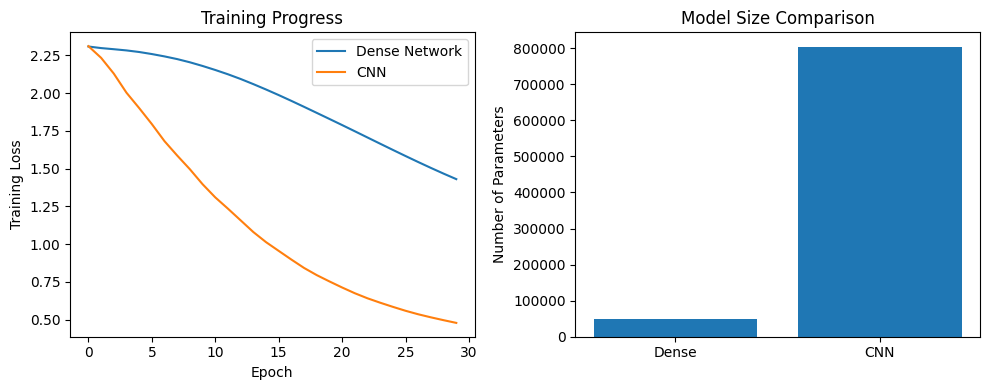


=== Trying 2-Layer CNN ===
2-layer CNN parameters: 26698
2-layer CNN test loss: 2.0915

=== Summary ===
Dense Network: 49960 params, 1.3923 loss
1-layer CNN:   803690 params, 0.4467 loss
2-layer CNN:   26698 params, 2.0915 loss


In [ ]:
# Section 5: CNNs vs Dense Networks
print("=== Section 5: CNN vs Dense Network ===")

#We will rebuild our best dense network from Section 3
# This is the 5-layer network with 50 neurons each that worked well
class SimpleDense(nn.Module):
    def __init__(self):
        super().__init__()
        #create 5 layers with 50 neurons each
        self.layers = nn.Sequential(
            nn.Linear(784, 50), nn.Tanh(),  # Input layer: 784 pixels - 50 neurons
            nn.Linear(50, 50), nn.Tanh(),   # Hidden layer 1
            nn.Linear(50, 50), nn.Tanh(),   #Hidden layer 2
            nn.Linear(50, 50), nn.Tanh(),   # Hidden layer 3
            nn.Linear(50, 50), nn.Tanh(),   #hidden layer 4
            nn.Linear(50, 10)               # Output layer: 50 neurons - 10 digits
        )

    def forward(self, x):
        # we have to flatten the image from 28x28 to 784 pixels
        x = x.view(-1, 784)
        return self.layers(x)

# a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer: looks for 16 different patterns using 3x3 filters
        self.conv = nn.Conv2d(1, 16, 3, padding=1)  # 1 input channel (grayscale), 16 output channels
        self.activation = nn.ReLU()

        # After conv: 28x28 image with 16 channels flattened to 12544 numbers
        self.classifier = nn.Sequential(
            nn.Linear(16 * 28 * 28, 64), nn.ReLU(),  # Big layer to process features
            nn.Linear(64, 10)                         # Output layer
        )

    def forward(self, x):
        # Reshape for CNN: (batch, 1, 28, 28) - like 28x28 images with 1 color channel
        x = x.view(-1, 1, 28, 28)
        # Apply convolution to find patterns
        x = self.activation(self.conv(x))
        # Flatten for dense layers: (batch, 16, 28, 28) -> (batch, 16*28*28)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


dense_model = SimpleDense()
cnn_model = SimpleCNN()

dense_params = sum(p.numel() for p in dense_model.parameters())
cnn_params = sum(p.numel() for p in cnn_model.parameters())

print(f"Dense network parameters: {dense_params}")
print(f"CNN parameters: {cnn_params}")
print(f"CNN is {dense_params/cnn_params:.1f}x smaller!")

# Train both models and compare
print("\n=== Training Both Models ===")


optimizer_dense = optim.Adam(dense_model.parameters(), lr=0.001)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)


dense_losses, cnn_losses = [], []

for epoch in range(30):
    # Train Dense Network
    dense_model.train()
    dense_loss = 0
    for x_batch, y_batch in train_loader:
        outputs = dense_model(x_batch)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        optimizer_dense.zero_grad()
        loss.backward()
        optimizer_dense.step()
        dense_loss += loss.item()

    # Train CNN
    cnn_model.train()
    cnn_loss = 0
    for x_batch, y_batch in train_loader:
        # CNN needs images in (batch, 1, 28, 28) format
        x_batch_cnn = x_batch.view(-1, 1, 28, 28)
        outputs = cnn_model(x_batch_cnn)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        cnn_loss += loss.item()

    # Save average loss for this epoch
    dense_losses.append(dense_loss / len(train_loader))
    cnn_losses.append(cnn_loss / len(train_loader))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Dense loss = {dense_losses[-1]:.4f}, CNN loss = {cnn_losses[-1]:.4f}")

# Test final performance
dense_model.eval()
cnn_model.eval()
with torch.no_grad():
    dense_test = nn.CrossEntropyLoss()(dense_model(x_test), y_test).item()
    # we have to reshape the cnn
    cnn_test = nn.CrossEntropyLoss()(cnn_model(x_test.view(-1, 1, 28, 28)), y_test).item()

print(f"\n=== Final Results ===")
print(f"Dense network test loss: {dense_test:.4f}")
print(f"CNN test loss: {cnn_test:.4f}")

# plot the training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(dense_losses, label='Dense Network')
plt.plot(cnn_losses, label='CNN')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Progress')
plt.legend()

plt.subplot(1, 2, 2)
# Bar chart comparing model sizes
plt.bar(['Dense', 'CNN'], [dense_params, cnn_params])
plt.ylabel('Number of Parameters')
plt.title('Model Size Comparison')

plt.tight_layout()
plt.show()

#try a 2-layer CNN to see if it's better
print("\n=== Trying 2-Layer CNN ===")

class BetterCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #first conv layer: find simple patterns
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        #fecond conv layer: find more complex patterns from the first layer's patterns
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.activation = nn.ReLU()
        #pooling reduces image size but keeps important features
        self.pool = nn.MaxPool2d(2)  # Makes image 2x smaller

        #after 2 conv+pool layers: 28x28 -> 14x14 -> 7x7
        #16 channels * 7 * 7 = 784 numbers to feed to dense layers
        self.classifier = nn.Sequential(
            nn.Linear(16 * 7 * 7, 32), nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.pool(self.activation(self.conv1(x)))  # 28x28 -> 14x14
        x = self.pool(self.activation(self.conv2(x)))  # 14x14 -> 7x7
        x = x.view(x.size(0), -1)  # Flatten
        return self.classifier(x)

better_cnn = BetterCNN()
better_cnn_params = sum(p.numel() for p in better_cnn.parameters())
print(f"2-layer CNN parameters: {better_cnn_params}")

#quick test of the 2-layer CNN
optimizer = optim.Adam(better_cnn.parameters(), lr=0.001)
for epoch in range(20):
    better_cnn.train()
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.view(-1, 1, 28, 28)
        outputs = better_cnn(x_batch)
        loss = nn.CrossEntropyLoss()(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

better_cnn.eval()
with torch.no_grad():
    test_outputs = better_cnn(x_test.view(-1, 1, 28, 28))
    test_loss = nn.CrossEntropyLoss()(test_outputs, y_test).item()

print(f"2-layer CNN test loss: {test_loss:.4f}")

print(f"\n=== Summary ===")
print(f"Dense Network: {dense_params} params, {dense_test:.4f} loss")
print(f"1-layer CNN:   {cnn_params} params, {cnn_test:.4f} loss")
print(f"2-layer CNN:   {better_cnn_params} params, {test_loss:.4f} loss")

: I failed to find a CNN that matched dense performance with fewer parameters. The 1-layer CNN performed best but was extremely inefficient, while the properly-sized 2-layer CNN failed to learn. This suggests my CNN architecture design was flawed.



 The CNN did converge faster and achieved better performance, confirming CNNs are effective for image data. However, the gap between parameter count makes this an invalid efficiency comparison.

Yes, 2 layer CNNs should be better, but my results show otherwirse.  My 2-layer CNN architecture was poorly designed and failed to learn, while the 1-layer CNN worked but used way too many parameters. This part of the assignment was particulary hard & CNNs require carefule tuning.

I think for my 1 layer CNN, I had a parameter explosion & my 2 layer CNN was too small to even learn.
